# PyTorch Transfer Learning
* Notebook by Adam Lang
* Date: 5/10/2025

# Overview
* This notebook is based on the concepts taught in Daniel Bourke's PyTorch for Deep Learning Bootcamp on Udemy.

* Although I have been coding in PyTorch since 2022, I continually review and brush up on my torch skills and Daniel Bourke is the best in the business at teaching tips and tricks to make you a PyTorch guru.

* As the great Kobe Bryant once said:
```
Mamba Mentality means "to constantly try to be the best version of yourself. It's a constant quest to try to better today than you were yesterday."
```
```
“Why do you think I’m the best player in the world? Because I never ever get bored with the basics.”
```

## 06. PyTorch Transfer Learning
* What is transfer learning?
  * Involves taking parameters of what a pre-trained or "Foundation" model has learned on a specific dataset and applying it to another problem.
  * Usually this means you are fine-tuning the model on your own dataset using the foundation model as the base model.

* What are pre-trained weights?
  * The original weights the foundation model was trained on.
  


In [1]:
import torch
import torchvision

## versions
print(torch.__version__) ## need 1.12+
print(torchvision.__version__) ## need 0.13+


2.6.0+cu124
0.21.0+cu124


Summary
* As you can see we have versions that are updated and most recent so we don't have to do anything else here.
* If you don't have the recent versions than you need to upgrade them.
* Now that we have the versions of torch and torchvision, we can import code from previous sections so we don't have to write it again.

In [2]:
# Continue with standard imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
# `torchinfo` --> info about our models
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 27.52 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Wed May 21 10:51:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data
* We need to go get the pizza, steak, sushi data to build a transfer learning model.

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")




Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [6]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders for Transfer Learning

Now we have some data, we want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in the going modular section.

There's one thing we need to think about when loading data: **how to we want to transform it?**

And with `torchvision` 0.13+ there are 2 ways to do this:

1. Manually created transforms -- you define what transforms you want your data to go through

2. Automatically created transforms -- the transforms for your data is defined by the model you would like to use.

Important point:
* When using a pre-trained model, it is important the data including your custom data that you pass through the model is **transformed** in the same way that the data the model was trained on.
* How do we take the images and transform the into tensors?

In [7]:
from going_modular.going_modular import data_setup


### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models that are ready for transfer learning within the torchvision library.

> All pre-trained models expect input images normalized in the same way, such as:
1. mini-batches of 3-channel RGB images of shape (3 x H x W),
2. ...where H and W are expected to be at least 224.
3. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize.
>
>

In [8]:
from torchvision import transforms

## normalize transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

## manual transforms --> you can customize this however you like
manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)), # resize image to 224, 224 (height x width)
                                        transforms.ToTensor(), # get images into range [0, 1]
                                        normalize]) # make sure images have same distributions as ImageNet (where pre-trained models were trained)

In [9]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32
                                                                               )
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cbaba8cfe50>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on pretrained model weights you are using.

In [10]:
import torchvision
torchvision.__version__

'0.21.0+cu124'

In [11]:
# Get set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights -- best performing weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# Get transforms used to create pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Summary
* These are all the weights the original transform was trained on.

In [13]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)


In [14]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cbaba8dbc90>,
 <torch.utils.data.dataloader.DataLoader at 0x7cbaba8d6690>)

Summary
* **Very important your custom data is transformed the same method/technique/format the pre-trained model was trained on. That is transfer learning 101.**

## 3. Getting a pretrained model

There are various places to get pretrained model:

1. PyTorch domain libraries
2. Libraries like`timm` (torch image models)
3. HuggingFace hub
4. Paperswithcode -- models in various domains

### 3.1 Which pretrained model should you use?

* Experiment, Experiment, experiment!!

The concept of transfer learning is to take an already well performing from a problem space similar to your own and then customize it to your own problem.

There are 3 things to consider when picking a model
1. **Speed**
  * how fast it runs
  * bits and bytes
2. **Size** and **Scalability**
  * num of parameters
  * Computational memory to load, store and utilize model.
3. **Performance**
  * how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?
  * `Acc@1`
  * `Acc@5`


Where does model live?
1. Is it on device? (e.g. mobile)
2. Does it live on server?


Looking at the model weights: https://docs.pytorch.org/vision/main/models.html

Which model should we choose and why?
* **Best tradeoff between highest accuracy and lowest number of parameters.**
* EfficientNet is generally good with best accuracy and params aren't too big.

#### Takeaways
1. However, for our case of deploying a model on a mobile device, it looks like `EffNetB0` is one of the best options in terms of performance vs size.

2. However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.

3. The Bitter Lesson: http://www.incompleteideas.net/IncIdeas/BitterLesson.html



### 3.2 Setting up pretrained model

Want to create instance of a pretrained `EffNet_B0`: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html


In [15]:
# old method of creating pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

In [16]:
# New method of creating pre-trained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = best available weights

## setup model with pretrained weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 50.3MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
## feature layers
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [18]:
## avg pool layers
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [19]:
## classifier head -- we will alter this for our transfer learning
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Summary
* `out_features = 1000` because model was pretrained on IMAGENET which has 1000 classes.
* However, we only had 3 classes for pizza, steak, sushi so we will need to change this!

#### EfficientNet Feature Extractor
* We are building a model to extract features from an image.
* Features can be anything:
  * shape
  * color
  * size
  * ...etc..
* Output feature vector is 1 single vector of size 1280.
  * Final vector is compressed.

* Final classifier layer turns raw logits --> prediction probabilities --> finally into classification labels.

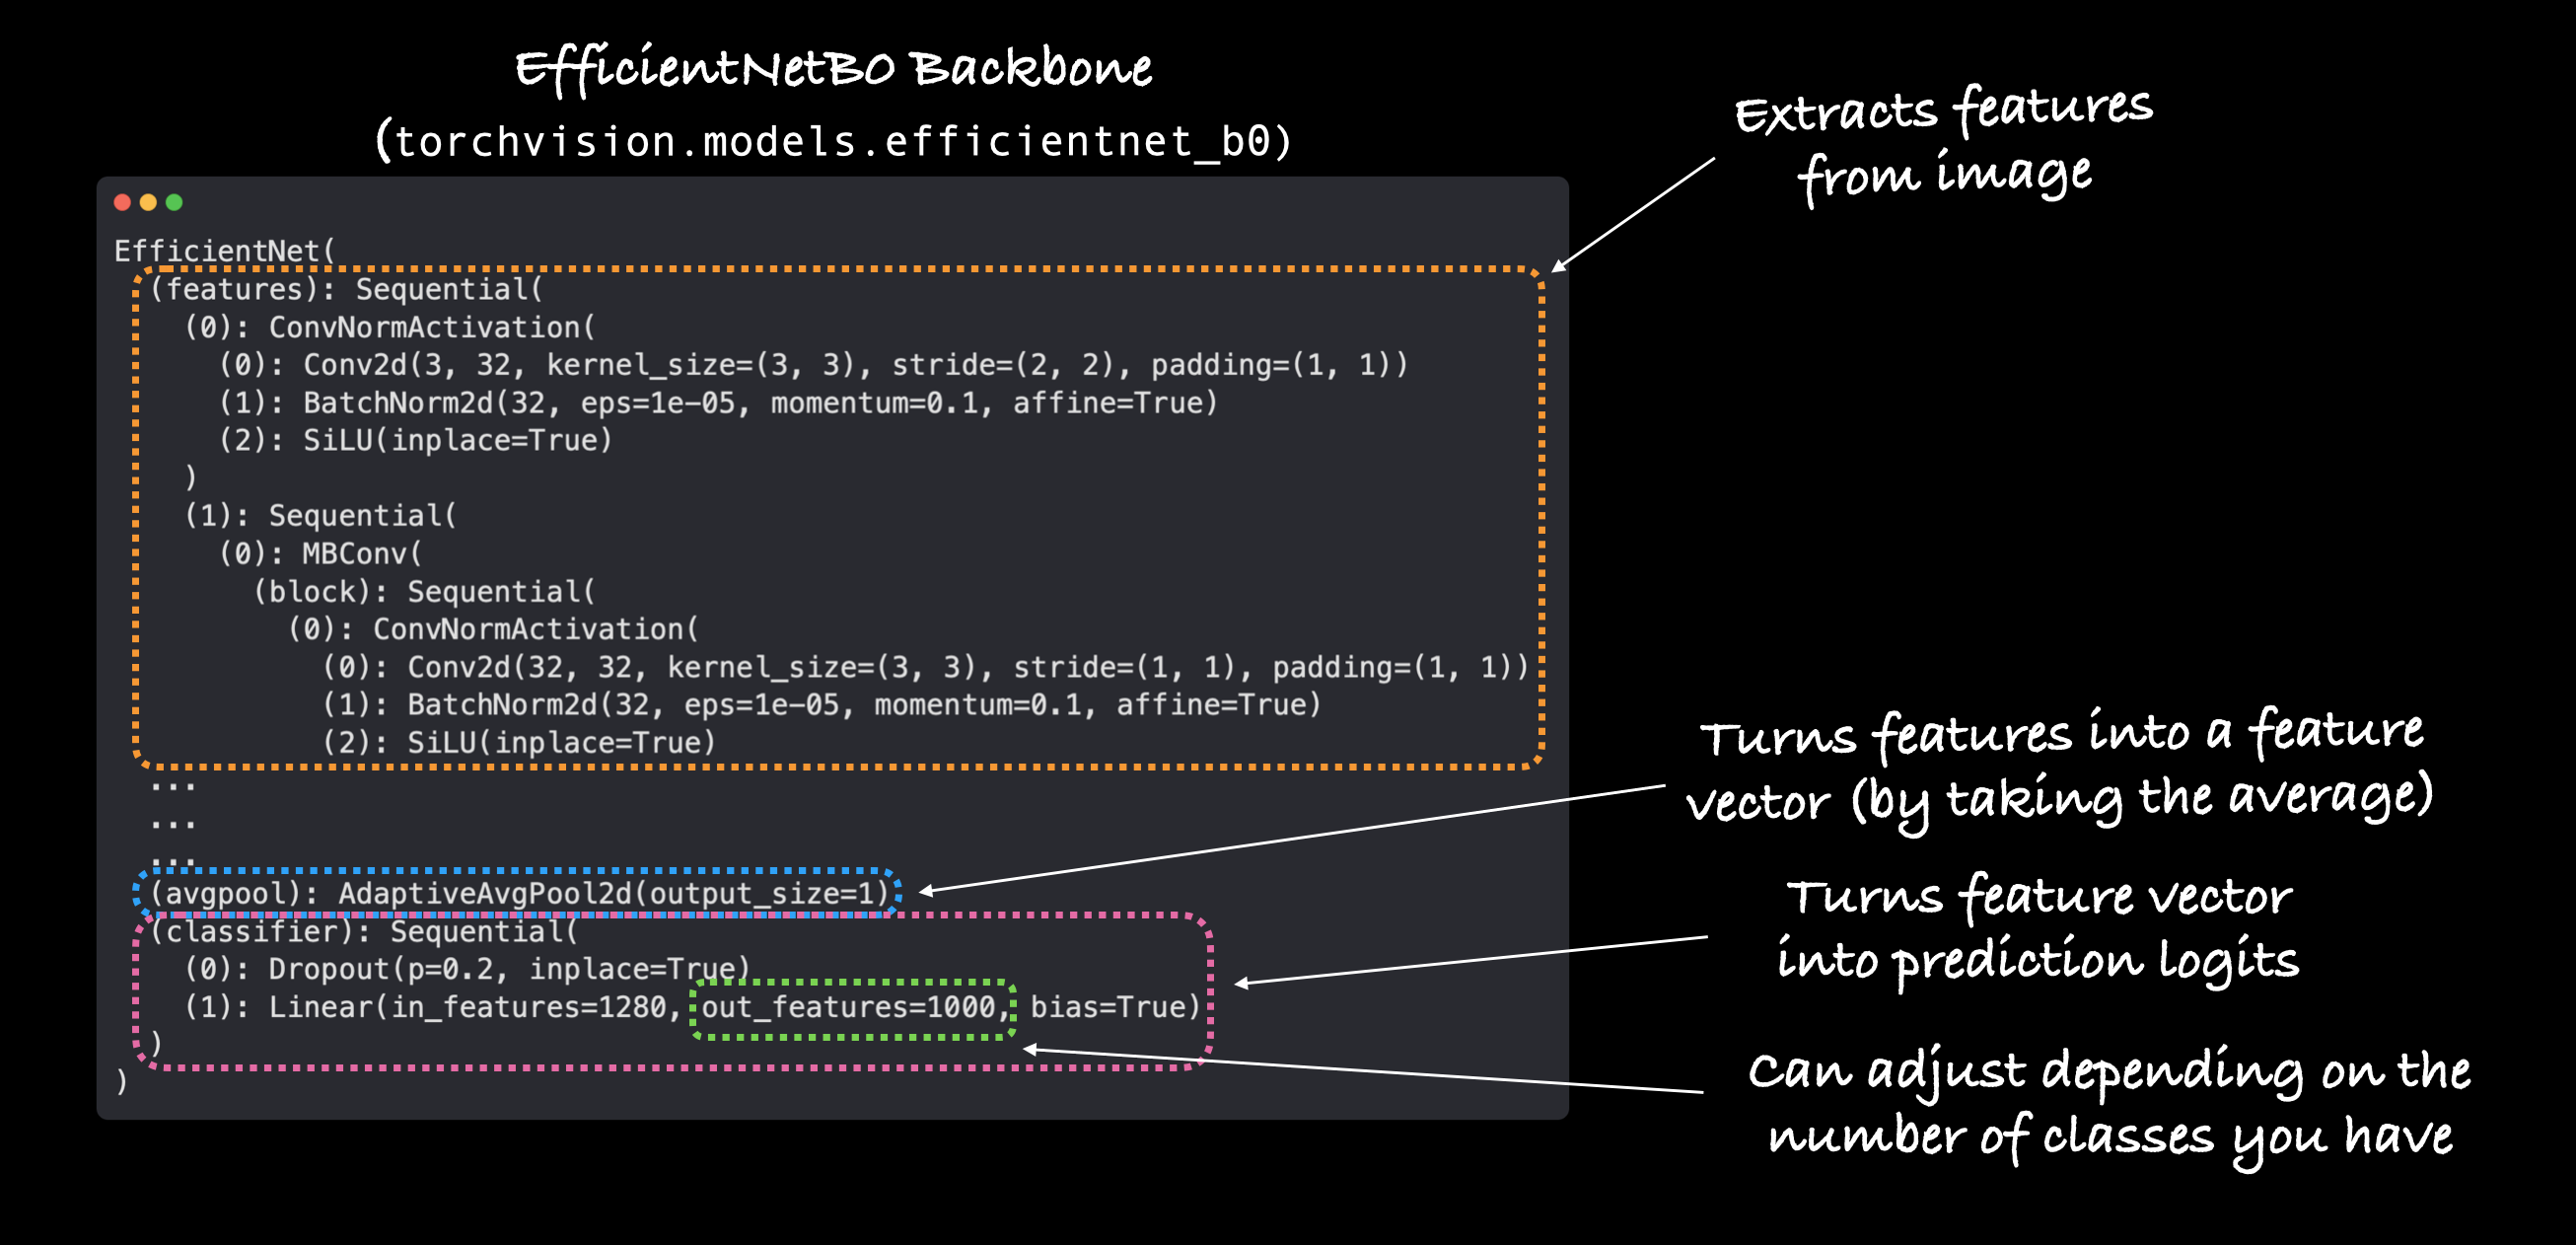

Summary
* Image source: Daniel Bourke PyTorch Deep Learning Bootcamp.
* Main takeaway is we are averaging all the features into 1 single output vector to predict the classification class we want: pizza, steak, sushi.

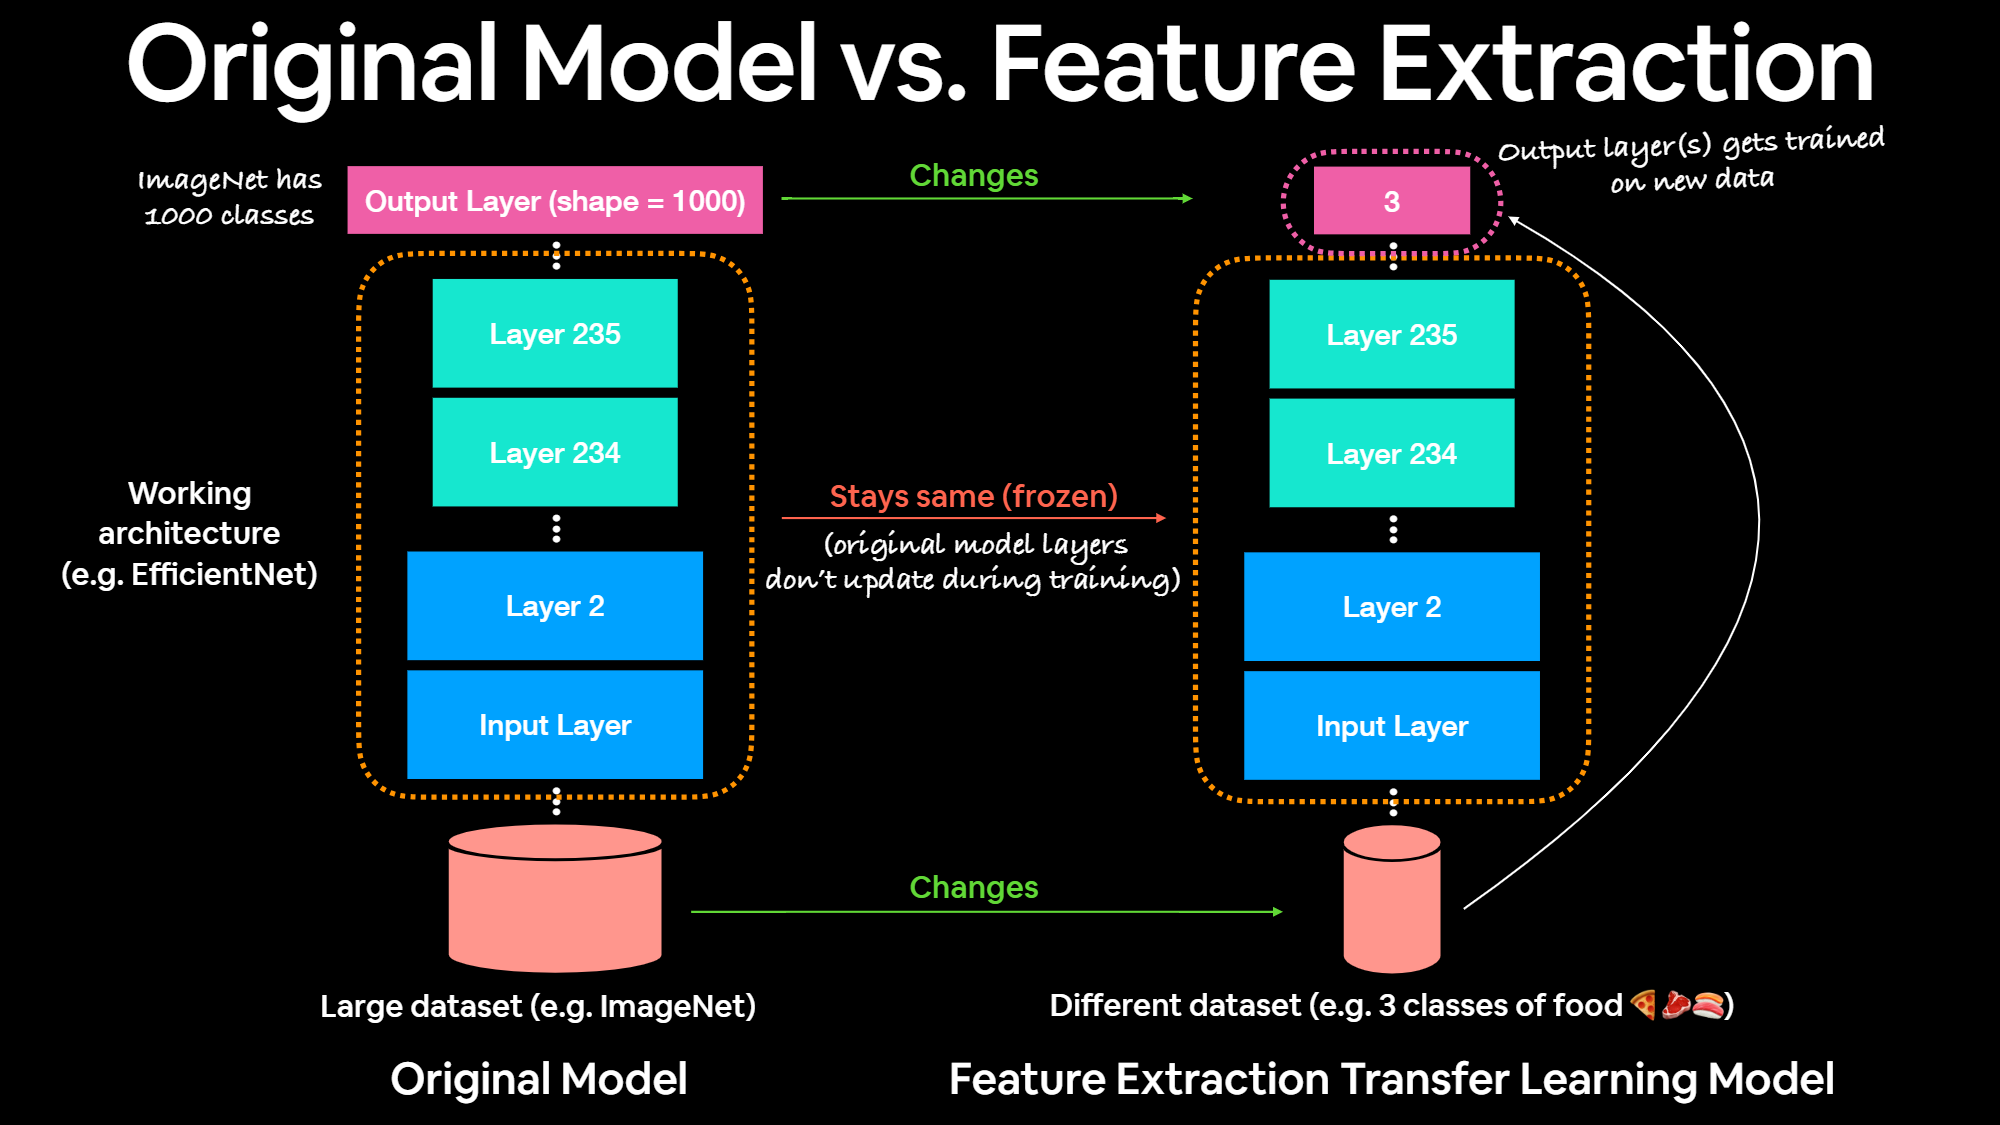

* Image above source: Daniel Bourke PyTorch Deep Learning Bootcamp.
* Takeaway: freeze backbone, change classification head.

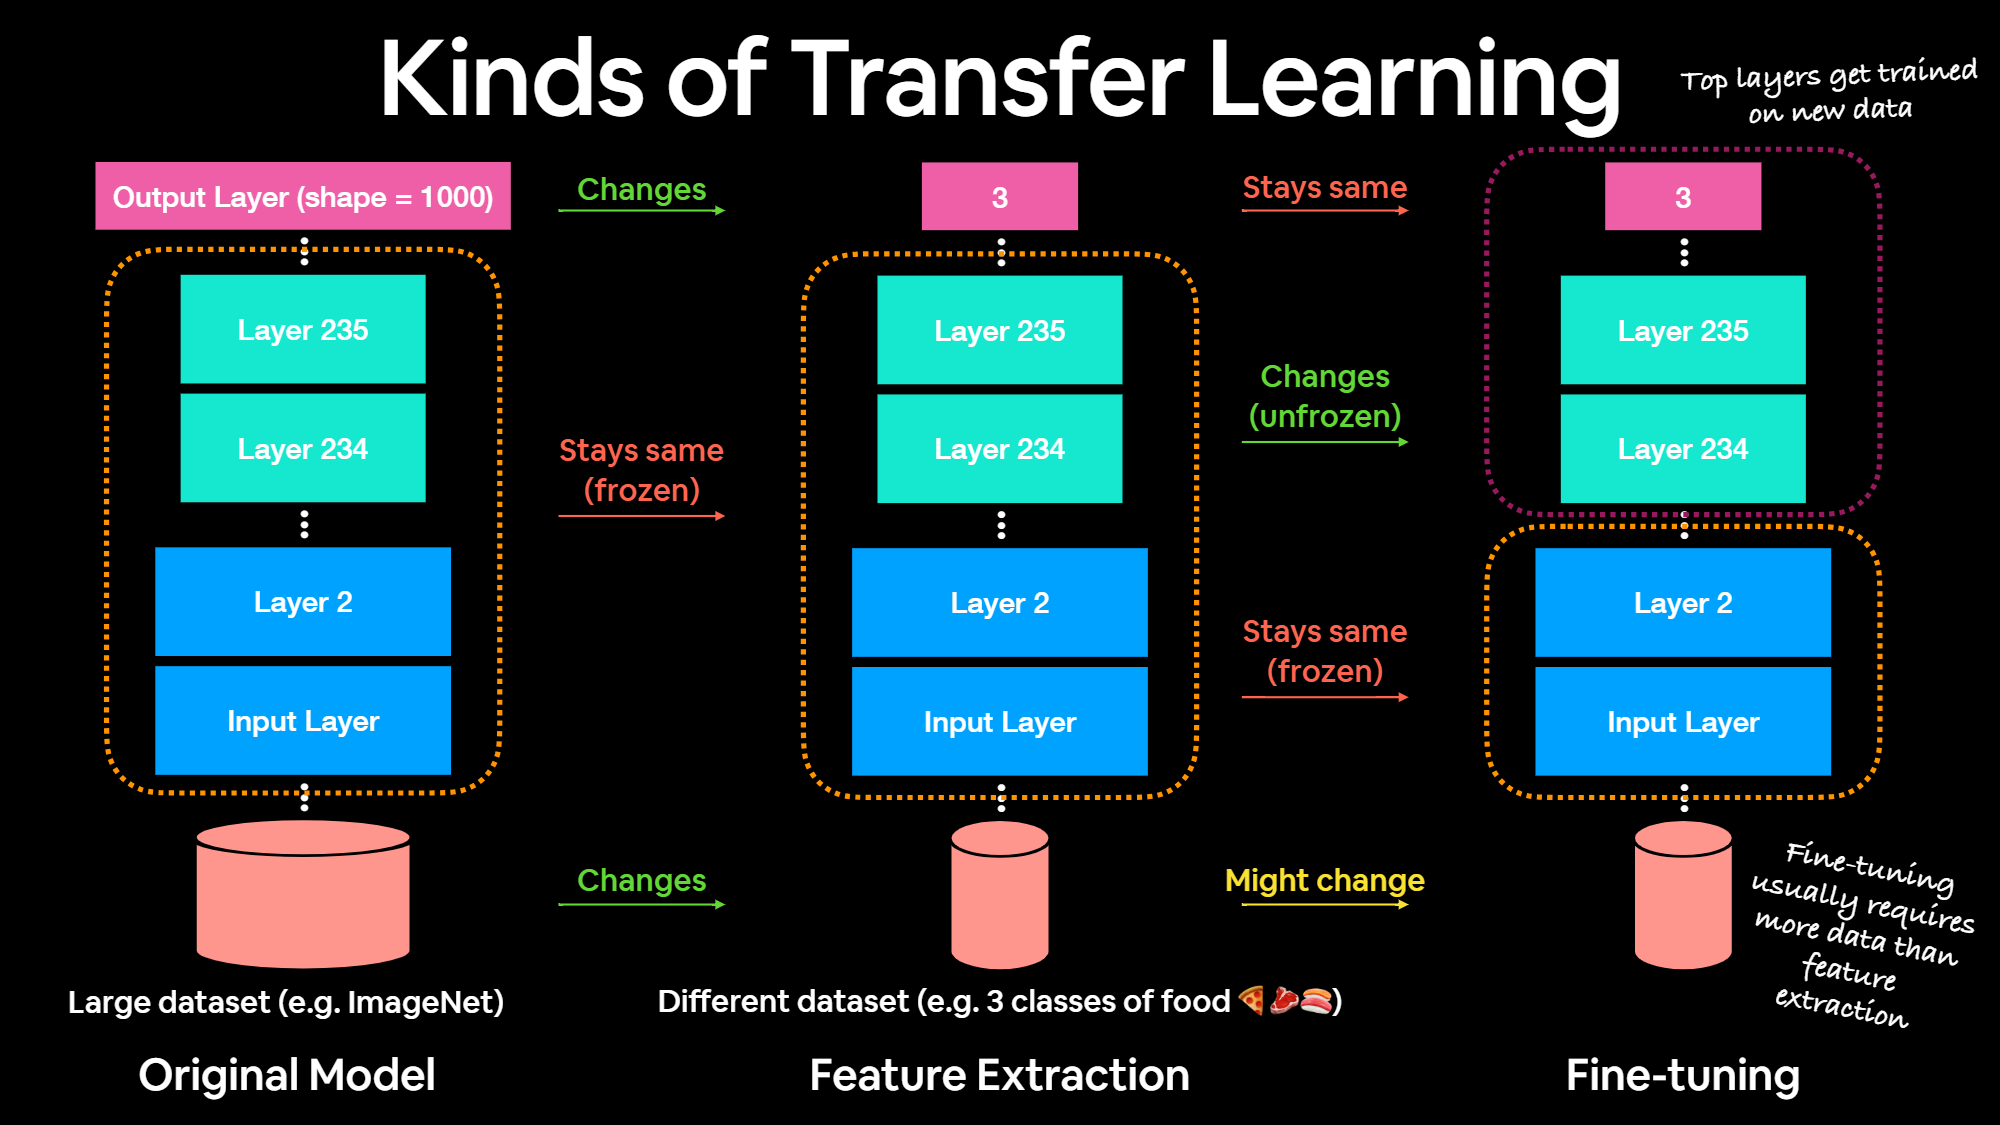

Summary
* Image above source: Daniel Bourke PyTorch Deep Learning Bootcamp.
* These are various approaches to transfer learning in ORDER of best approaches
1. **Original model unchanged**
  * If your data is the same as the original model.
  * **Here we use the model "as is"**
2. **Feature Extraction**
  * If have small amount of custom data to get better results on specific problem.
  * Most of the layers in the original model remain frozen during training, only the top 1-3 layers get updated.

3. **Fine-tuning**
  * LARGE amounts of custom data.
  * Use pretrained model but train on your data.
  * Some or all layers of the pretrained model are updated during training process.

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [20]:
# pritn summary with torchinfo
from torchinfo import summary

## get summary
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width] --> 1 image
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

Summary
* Takes in input shape of 1, 224, 224
* Outputs shape of 1, 1000
```
─Sequential (classifier)                                    [1, 1280]            [1, 1000]            --                   True
│    └─Dropout (0)                                           [1, 1280]            [1, 1280]            --                   --
│    └─Linear (1)                                            [1, 1280]            [1, 1000]            1,281,000
```

We only want the linear classifier layer to be trainable.

Thus, we want to freeze the base layers and train the classifier layer.

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extraction model, typically we will "freeze the base layers" of a pretrained/foundation model and update the output layers to apply to our problem..

In [21]:
## we want to freeze the feature layers
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [22]:
# Freeze all base layers in EffNetB0
for param in model.features.parameters():
  # print(param) ## all pre-trained weights with gradients
  param.requires_grad = False ## freeze params and turn off gradients

Let's see the summary now that the features/base layers were frozen

In [23]:
# print summary with torchinfo
from torchinfo import summary

## get summary
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width] --> 1 image
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Summary
* We can see only the frozen output layer is trainable NOT the whole model.

In [24]:
# get number of classes
len(class_names)

3

In [25]:
## Now we can update the classifier head of the model to suit our problem
from torch import nn

# set seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # 20% of vectors will be dropped out to zero
    nn.Linear(in_features=1280, # feature vectors coming in
              out_features=len(class_names))).to(device) # how many classes do we have/need? only 3,



model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

Summary
* Randomly adding drop out layers will zero out some nodes in the neural network which will allow the remaining nodes to learn the patterns of the data and hopefully the network becomes more generalizeable on unseen data thus preventing overfitting of the model.  

* We need to keep these layers similar in Sequential if we want to update the original architecture of the model.

In [26]:
## get summary again
#from torchinfo import summary

## get summary
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width] --> 1 image
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Summary
* Now we can see that most of the parameters are NOT trainable (False).
* We froze all of the base layers.
* We updated the output classifier head.
* Total trainable params are only a small percentage of the original model.

## 4. Train model


In [27]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss() ## multi-class classification
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

In [28]:
# import train function from engine.py
from going_modular.going_modular import engine

# set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start timer
from timeit import default_timer as timer
start_time = timer()

# setup training and save results --> use train function
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 16.773 seconds


Summary
* The new model shows test accuracy of 85% which is much improved from the original model which had a poor test accuracy of around 60%.
* Clearly the feature extraction with training only the classifier head made the model more accurate.

In [29]:
## lets print results
results

{'train_loss': [1.0924270078539848,
  0.8716965168714523,
  0.7647949680685997,
  0.7108824849128723,
  0.6254763826727867],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9132681687672933,
  0.7911976178487142,
  0.7463406721750895,
  0.6373109420140585,
  0.6261005997657776],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061]}

## 5. Evaluate model by plotting loss curves

[INFO] Couldn't fine helper_functions.py, downloading...


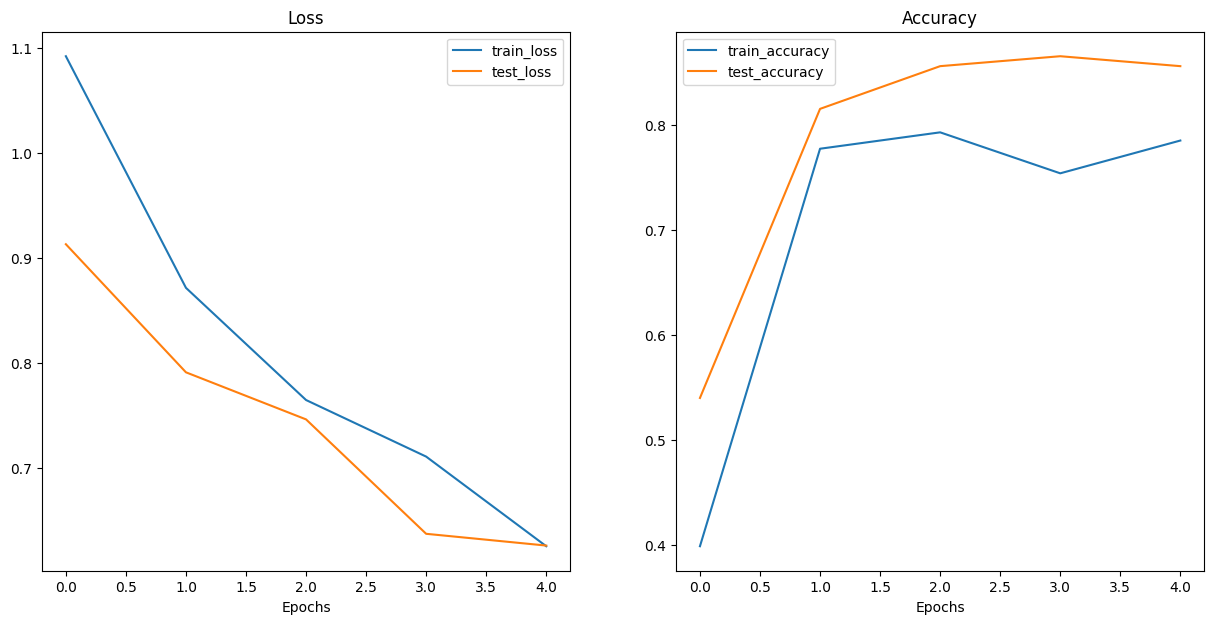

In [30]:
## download helper_functions plotting script
try:
  from helper_functions import plot_loss_curves
  print("failed")
except:
  print("[INFO] Couldn't fine helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot loss curves of model
plot_loss_curves(results)

Summary
* If we trained the model for longer the loss could improve (e.g. go lower), and the accuracy may improve.
* Consider what an ideal loss curve should look like: https://wandb.ai/mostafaibrahim17/ml-articles/reports/A-Deep-Dive-Into-Learning-Curves-in-Machine-Learning--Vmlldzo0NjA1ODY0


Lets try 10 epochs and see result

In [31]:
# import train function from engine.py
from going_modular.going_modular import engine

# set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start timer
from timeit import default_timer as timer
start_time = timer()

# setup training and save results --> use train function
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5289 | train_acc: 0.9258 | test_loss: 0.5675 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.4793 | train_acc: 0.9297 | test_loss: 0.5215 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.4518 | train_acc: 0.9219 | test_loss: 0.5251 | test_acc: 0.8551
Epoch: 4 | train_loss: 0.4759 | train_acc: 0.8398 | test_loss: 0.4815 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.4072 | train_acc: 0.9570 | test_loss: 0.4943 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.4402 | train_acc: 0.8203 | test_loss: 0.4729 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.4078 | train_acc: 0.9453 | test_loss: 0.4560 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.4280 | train_acc: 0.8320 | test_loss: 0.4499 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5003 | train_acc: 0.8242 | test_loss: 0.4426 | test_acc: 0.8352
Epoch: 10 | train_loss: 0.4109 | train_acc: 0.8320 | test_loss: 0.3863 | test_acc: 0.9062
[INFO] Total training time: 23.296 seconds


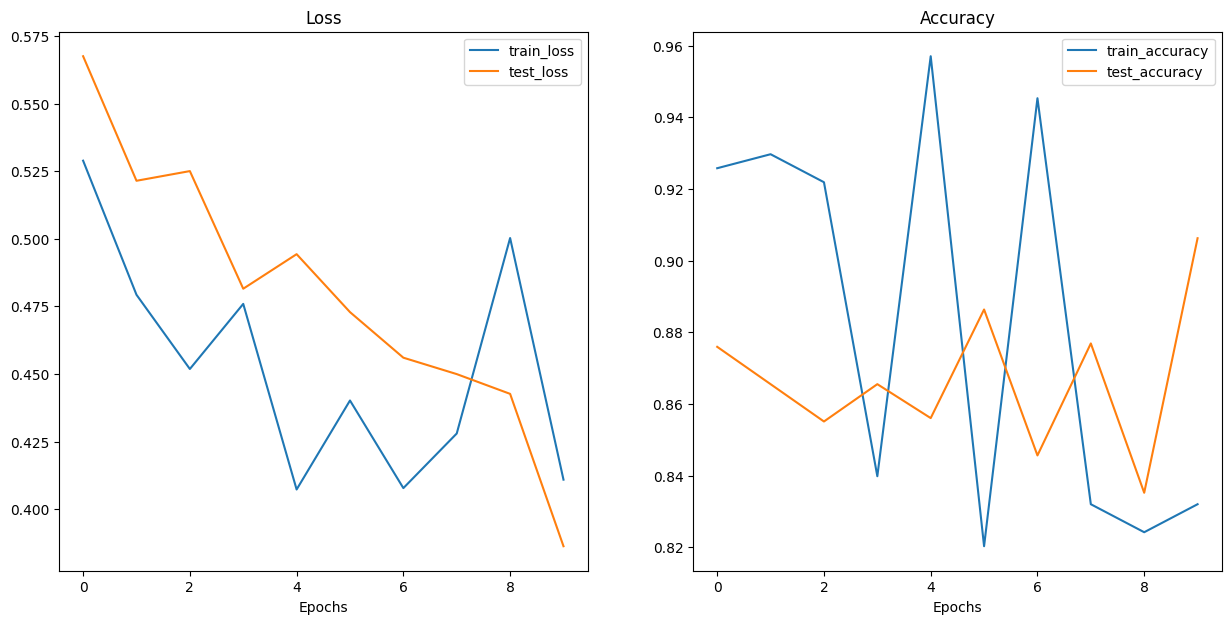

In [32]:
# Plot loss curves of model with 10 epochs
plot_loss_curves(results)

Summary
* The loss is improved, but now we can see an oscillating accuracy.

* Several factors can contribute to oscillating test accuracy:

1. Learning Rate:
  * A learning rate that is too high can cause the model to jump around in parameter space, leading to unstable performance.
2. Batch Size:
  * Small batch sizes can make the training process noisy, leading to fluctuations in accuracy.

3. Data Quality and Representation:
  * An unbalanced or poorly represented validation set can also lead to noisy validation loss and accuracy.

4. Overfitting:
  * If the model learns the training data too well, it may not generalize well to the test set, leading to oscillations in performance.
5. Model Complexity:
  * A complex model can be more prone to overfitting, especially with a limited amount of data.
6. Optimizer:
  * Different optimizers can have different effects on training stability.

* Addressing Oscillating Test Accuracy:

1. Adjust Learning Rate
  * Try using a smaller learning rate or implementing a learning rate scheduler.

2. Increase Batch Size
  * Larger batch sizes can help smooth out the training process.

3. Ensure Data Representation
  * Make sure your validation set is representative of the data distribution and large enough to provide reliable results.

4. Regularization Techniques
  * Techniques like dropout or weight decay can help prevent overfitting.

5. Simplify the Model
  * If overfitting is a concern, consider simplifying the model architecture.

6. Experiment with Optimizers
  * Try different optimizers and schedulers to see if they improve stability.

## 6. Make predictions on images from test set

Let's adhere to data explorers motto of "visualize, visualize,visualize"!

We will make some qualitative predictions on the test set.

Some things to keep in mind when making predictions/inference on test data/custom data:
1. Make sure test/custom data is:
  * Same shape - images need to be same shape as model was trained on.
  * Same dtypes - custom data should be same data type.
  * Same device - custom data/test data should be on same device as model.
  * Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same.

To do all of this, lets create a function called `pred_and_plot_image()`:

1. Take in the following:
  * trained model
  * list of class names
  * filepath to target image
  * image size
  * transform
  * target device

2. Open the image with `PIL.Image.Open()`

3. Create transform if one does not exist.

4. Make sure model is on the target device! -- and data on same device.

5. Turn model to `model.eval()` model to make sure its ready for inference (this will turn off things like `nn.Dropout()`)

6. Transform target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)

7. Make prediction on image by passing to model.


8. Convert model's output logits to prediction probs using `torch.softmax()`

9. Convert model's pred probs to pred labels using `torch.argmax()`

10. Plot image with `matplotlib` and set title to prediction label from step 9 and pred prob from step 8.


In [45]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open image with PIL
  img = Image.open(image_path)

  # 3. Create transform if one does not exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                         transforms.Resize(image_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], # same as ImageNet dataseat
                                                              std=[0.229, 0.224, 0.225])
    ])
    ### Predict on image ###
    # 4. Make sure model is on target device
    model.to(device)

    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform the image and add extra batch dimension --> 1 image at a time
      transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

      # 7. Make prediction on transformed image by passing it to model (also ensure on target device)
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert model's output logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    print(target_image_pred_probs.max())

    # 9. Convert model's pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

In [46]:
# Get a random list of image paths from the test set
import random
num_images_to_plot=3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
# len(test_image_path_list)--> there's 75, we only want to sample 3 or so
## get sample
test_image_path_sample = random.sample(population=test_image_path_list,
                                      k=num_images_to_plot)

## get sample paths
test_image_path_sample

[PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg')]

tensor(0.8476, device='cuda:0')
tensor(0.4953, device='cuda:0')
tensor(0.9058, device='cuda:0')


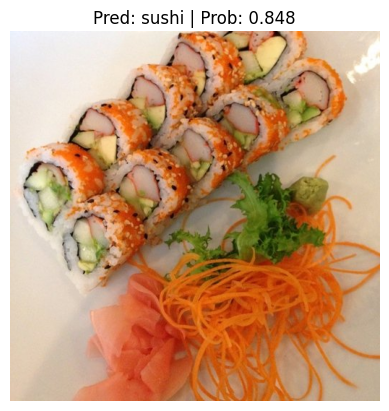

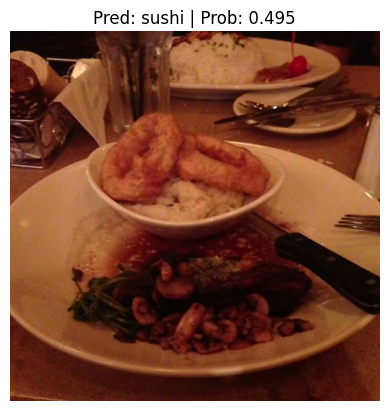

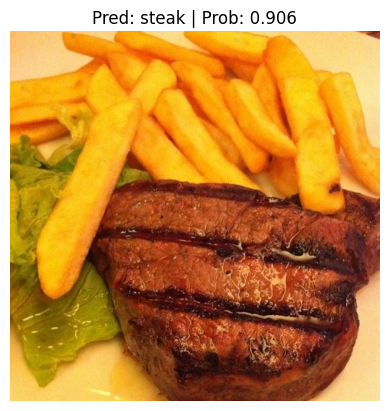

In [49]:
## Make predictions on and plot images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

### 6.1 Making Predictions on custom image

Let's make prediction on a random image.

In [52]:
# download the raw image path
import requests

# Setup custom image path
custom_image_path = data_path / "Tomahawk-steak.jpeg"

# Download image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # Download image from raw link
    #request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    request = requests.get("https://assets2.kansascitysteaks.com/dyn-images/pdp_hero/Cooked_Sliced_Tomaha-60acb544fb1e4d9dae19fd08febcf437.jpg")
    print(f"Download {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

Download data/Tomahawk-steak.jpeg...


tensor(0.4950, device='cuda:0')


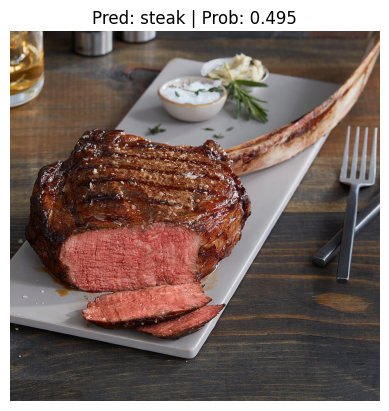

In [53]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

Summary
* We can see with an image of a tomahawk steak the probability was less than 50% prediction so if we were to train the model on more samples including more various types of steak with some transformations we might get an improved prediction.